In [1]:
# ============================================================================
# 01_DATA_PREPARATION.IPYNB
# ============================================================================
# PURPOSE: Load, explore, and split dataset into train/val/test sets
# TIME ESTIMATE: 10-15 minutes (CPU only, no GPU needed)
# ============================================================================

# UNSAFE Content Classification - Data Preparation

## Objective
Prepare the news article dataset for two-stage cascade training:
- Stage 1: Binary UNSAFE detector (UNSAFE vs NOT_UNSAFE)
- Stage 2: SAFE/SENSITIVE classifier

## Strategy
- Use `summary_long_500` (400 words) as input text
- 70/15/15 stratified split by label AND category
- Create separate datasets for each training stage
- Calculate class weights for handling imbalance

## 1. Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import os
import json

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

notebook_dir = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(notebook_dir, '..'))

print(f"Project root: {PROJECT_ROOT}")
print("✓ Setup complete")

Project root: /blue/eee6778/koshyreshma/MiniNewsAI
✓ Setup complete


## 2. Load and Explore Dataset

**Rationale:** Understanding data distribution is critical for:
- Identifying class imbalance (UNSAFE is minority class at ~19.7%)
- Ensuring all categories are represented
- Detecting any data quality issues

In [3]:
# Load the dataset
# CHANGE THIS PATH to your actual data file location
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'raw', 'original_data.csv')

df = pd.read_csv(DATA_PATH)

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

DATASET OVERVIEW

Shape: (7068, 9)

Columns: ['id', 'category', 'summary_500', 'label', 'reasoning', 'confidence', 'body', 'summary_long_500', 'body_length']

Data types:
id                    int64
category             object
summary_500          object
label                object
reasoning            object
confidence          float64
body                 object
summary_long_500     object
body_length           int64
dtype: object

Missing values:
id                  0
category            0
summary_500         0
label               0
reasoning           0
confidence          0
body                0
summary_long_500    0
body_length         0
dtype: int64


In [4]:
# Display sample rows
print("\n" + "="*80)
print("SAMPLE DATA")
print("="*80)
print(df[['category', 'label', 'summary_long_500']].head(3))

# Check text lengths
df['text_length_words'] = df['summary_long_500'].str.split().str.len()
df['text_length_chars'] = df['summary_long_500'].str.len()

print("\n" + "="*80)
print("TEXT LENGTH STATISTICS (summary_long_500)")
print("="*80)
print(f"Average words: {df['text_length_words'].mean():.0f}")
print(f"Min words: {df['text_length_words'].min()}")
print(f"Max words: {df['text_length_words'].max()}")
print(f"Std words: {df['text_length_words'].std():.0f}")


SAMPLE DATA
         category   label  \
0  ARTS & CULTURE  UNSAFE   
1  ARTS & CULTURE  UNSAFE   
2  ARTS & CULTURE  UNSAFE   

                                                                                      summary_long_500  
0  Carolyn Kramer worked as a modeling agent in New York City in the 1980s, ’90s and early 2000s. S...  
1  Jeff Hiller will step in the role of Gerry in the hit Off Broadway play Bright Colors And Bold P...  
2  President Donald Trump sparked widespread criticism after he reportedly questioned why the U.S. ...  

TEXT LENGTH STATISTICS (summary_long_500)
Average words: 187
Min words: 73
Max words: 293
Std words: 41


## 3. Analyze Label Distribution

**Key Insight:** UNSAFE is the minority class (~19.7%)
- This imbalance requires special handling (class weights, focal loss)
- Our goal: 90%+ UNSAFE recall (catch 90%+ of dangerous content)
- Trade-off: Accept lower precision (more false alarms)


LABEL DISTRIBUTION
           Count  Percentage
label                       
SENSITIVE   3043   43.053198
SAFE        2754   38.964346
UNSAFE      1271   17.982456


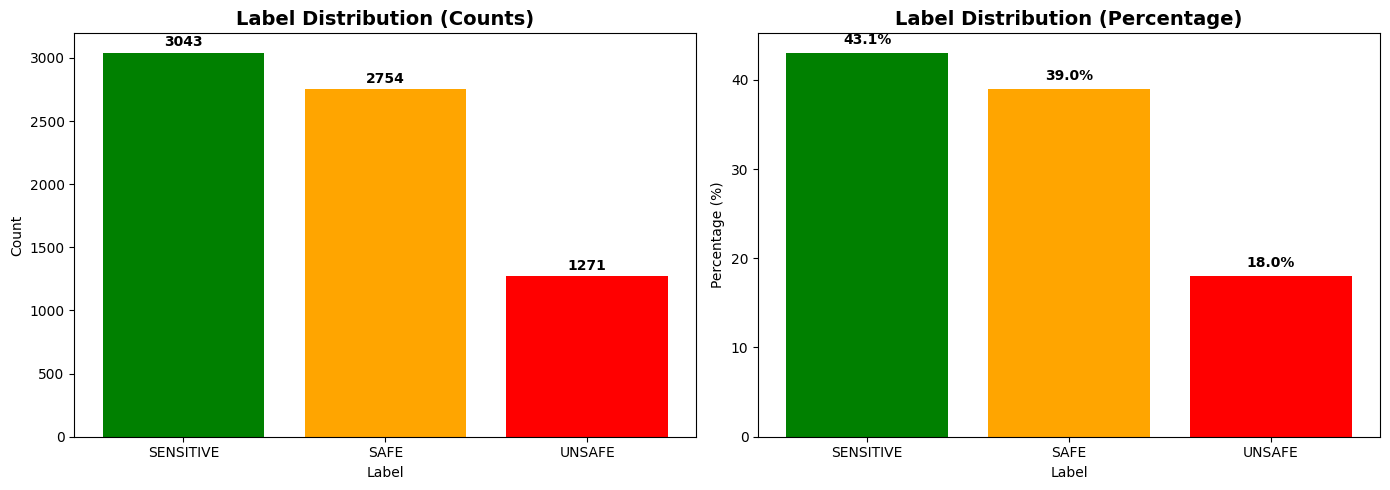


Imbalance ratio (SAFE:UNSAFE): 2.17:1
→ This is MODERATE imbalance (not extreme)
→ Weighted loss + focal loss should handle this well


In [5]:
print("\n" + "="*80)
print("LABEL DISTRIBUTION")
print("="*80)

label_counts = df['label'].value_counts()
label_percentages = df['label'].value_counts(normalize=True) * 100

label_stats = pd.DataFrame({
    'Count': label_counts,
    'Percentage': label_percentages
})
print(label_stats)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(label_counts.index, label_counts.values, color=['green', 'orange', 'red'])
axes[0].set_title('Label Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Label')
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Percentage plot
axes[1].bar(label_percentages.index, label_percentages.values, color=['green', 'orange', 'red'])
axes[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Label')
for i, v in enumerate(label_percentages.values):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()

plt.savefig(os.path.join(PROJECT_ROOT, 'results', 'label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate imbalance ratio
unsafe_count = label_counts['UNSAFE']
safe_count = label_counts['SAFE']
imbalance_ratio = safe_count / unsafe_count
print(f"\nImbalance ratio (SAFE:UNSAFE): {imbalance_ratio:.2f}:1")
print("→ This is MODERATE imbalance (not extreme)")
print("→ Weighted loss + focal loss should handle this well")

## 4. Analyze Category Distribution

**Rationale:** Ensure stratified split maintains category balance
- Different categories may have different UNSAFE patterns
- Want representative samples from each category in train/val/test


CATEGORY DISTRIBUTION
category
ENVIRONMENT       2233
ARTS & CULTURE    1968
SPORTS            1492
SCIENCE           1375
Name: count, dtype: int64

LABEL × CATEGORY CROSS-TABULATION
label           SAFE  SENSITIVE  UNSAFE   All
category                                     
ARTS & CULTURE   679        765     524  1968
ENVIRONMENT      814       1209     210  2233
SCIENCE          684        499     192  1375
SPORTS           577        570     345  1492
All             2754       3043    1271  7068


<Figure size 1200x600 with 0 Axes>

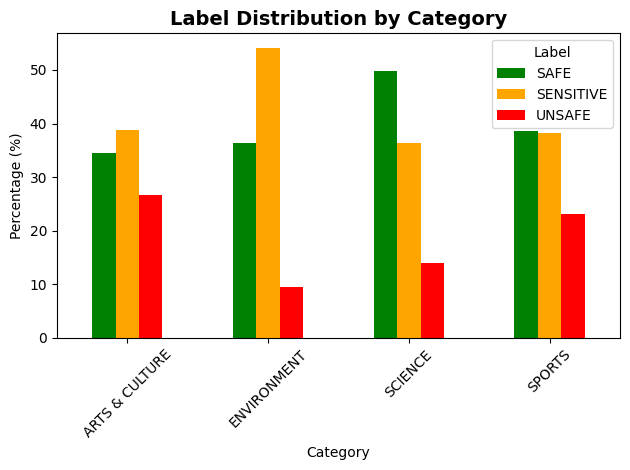


→ Categories have varying UNSAFE percentages
→ ENVIRONMENT has highest sample count (3256)
→ SCIENCE has lowest sample count (1760)
→ Stratified split will maintain these proportions


In [6]:
print("\n" + "="*80)
print("CATEGORY DISTRIBUTION")
print("="*80)

category_counts = df['category'].value_counts()
print(category_counts)

# Cross-tabulation: Label x Category
print("\n" + "="*80)
print("LABEL × CATEGORY CROSS-TABULATION")
print("="*80)
cross_tab = pd.crosstab(df['category'], df['label'], margins=True)
print(cross_tab)

# Visualize
plt.figure(figsize=(12, 6))
cross_tab_pct = pd.crosstab(df['category'], df['label'], normalize='index') * 100
cross_tab_pct.plot(kind='bar', stacked=False, color=['green', 'orange', 'red'])
plt.title('Label Distribution by Category', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)')
plt.xlabel('Category')
plt.legend(title='Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'results', 'category_label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n→ Categories have varying UNSAFE percentages")
print("→ ENVIRONMENT has highest sample count (3256)")
print("→ SCIENCE has lowest sample count (1760)")
print("→ Stratified split will maintain these proportions")

## 5. Prepare Data for Splitting

**Strategy:** 
- Select only needed columns: text, label, category
- Create combined stratification key (label_category)
- This ensures splits maintain both label AND category proportions

In [7]:
# Select and rename columns
df_clean = df[['summary_long_500', 'label', 'category']].copy()
df_clean.columns = ['text', 'label', 'category']

# Remove temporary length columns from original df
df = df.drop(['text_length_words', 'text_length_chars'], axis=1, errors='ignore')

print(f"\nCleaned dataset shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns.tolist()}")

# Create stratification column
# This ensures splits maintain proportions across BOTH label AND category
df_clean['strat_key'] = df_clean['label'] + '_' + df_clean['category']

print(f"\nUnique stratification keys: {df_clean['strat_key'].nunique()}")
print("(Should be 12: 3 labels × 4 categories)")

# Verify no missing values
assert df_clean.isnull().sum().sum() == 0, "ERROR: Missing values detected!"
print("\n✓ No missing values")


Cleaned dataset shape: (7068, 3)
Columns: ['text', 'label', 'category']

Unique stratification keys: 12
(Should be 12: 3 labels × 4 categories)

✓ No missing values


## 6. Stratified Train/Val/Test Split

**Split Strategy:**
- 70% Train (6,925 samples) - For model training
- 15% Validation (1,484 samples) - For hyperparameter tuning, threshold selection
- 15% Test (1,484 samples) - For final evaluation (NEVER touch until end)

**Why Stratified?**
- Maintains ~19.7% UNSAFE in all splits
- Maintains category proportions in all splits
- Prevents train/val/test from having different distributions

In [8]:
print("\n" + "="*80)
print("PERFORMING STRATIFIED SPLIT")
print("="*80)

# First split: 70% train, 30% temporary
train_df, temp_df = train_test_split(
    df_clean,
    test_size=0.30,
    random_state=RANDOM_SEED,
    stratify=df_clean['strat_key']  # Stratify by label + category
)

# Second split: Split temp into 50-50 (giving us 15% val, 15% test)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=RANDOM_SEED,
    stratify=temp_df['strat_key']
)

# Remove stratification key (not needed anymore)
train_df = train_df.drop('strat_key', axis=1).reset_index(drop=True)
val_df = val_df.drop('strat_key', axis=1).reset_index(drop=True)
test_df = test_df.drop('strat_key', axis=1).reset_index(drop=True)

print(f"Train size: {len(train_df)} ({len(train_df)/len(df_clean)*100:.1f}%)")
print(f"Val size: {len(val_df)} ({len(val_df)/len(df_clean)*100:.1f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/len(df_clean)*100:.1f}%)")


PERFORMING STRATIFIED SPLIT
Train size: 4947 (70.0%)
Val size: 1060 (15.0%)
Test size: 1061 (15.0%)


## 7. Verify Split Quality

**Critical Check:** Ensure UNSAFE percentage is consistent across splits
- If splits have very different UNSAFE%, the split failed
- All should be ~19.7% ± 1%

In [9]:
print("\n" + "="*80)
print("SPLIT VERIFICATION")
print("="*80)

def analyze_split(df, split_name):
    """Analyze label and category distribution in a split"""
    print(f"\n{split_name.upper()} SET:")
    print(f"  Total samples: {len(df)}")
    
    # Label distribution
    label_dist = df['label'].value_counts()
    label_pct = df['label'].value_counts(normalize=True) * 100
    
    print(f"\n  Label distribution:")
    for label in ['SAFE', 'SENSITIVE', 'UNSAFE']:
        count = label_dist.get(label, 0)
        pct = label_pct.get(label, 0)
        print(f"    {label}: {count} ({pct:.1f}%)")
    
    # Category distribution
    category_dist = df['category'].value_counts()
    print(f"\n  Category distribution:")
    for cat in category_dist.index:
        print(f"    {cat}: {category_dist[cat]}")
    
    return label_pct.get('UNSAFE', 0)

# Analyze each split
train_unsafe_pct = analyze_split(train_df, 'train')
val_unsafe_pct = analyze_split(val_df, 'validation')
test_unsafe_pct = analyze_split(test_df, 'test')

# Check consistency
print("\n" + "="*80)
print("UNSAFE PERCENTAGE CONSISTENCY CHECK")
print("="*80)
print(f"Train: {train_unsafe_pct:.2f}%")
print(f"Val:   {val_unsafe_pct:.2f}%")
print(f"Test:  {test_unsafe_pct:.2f}%")
print(f"Difference: {max(train_unsafe_pct, val_unsafe_pct, test_unsafe_pct) - min(train_unsafe_pct, val_unsafe_pct, test_unsafe_pct):.2f}%")

if abs(train_unsafe_pct - val_unsafe_pct) < 1.5 and abs(train_unsafe_pct - test_unsafe_pct) < 1.5:
    print("\n✓ SPLIT QUALITY: EXCELLENT")
    print("  All splits have similar UNSAFE percentages")
else:
    print("\n⚠ SPLIT QUALITY: CHECK NEEDED")
    print("  Splits have different UNSAFE percentages")


SPLIT VERIFICATION

TRAIN SET:
  Total samples: 4947

  Label distribution:
    SAFE: 1928 (39.0%)
    SENSITIVE: 2129 (43.0%)
    UNSAFE: 890 (18.0%)

  Category distribution:
    ENVIRONMENT: 1563
    ARTS & CULTURE: 1377
    SPORTS: 1045
    SCIENCE: 962

VALIDATION SET:
  Total samples: 1060

  Label distribution:
    SAFE: 412 (38.9%)
    SENSITIVE: 456 (43.0%)
    UNSAFE: 192 (18.1%)

  Category distribution:
    ENVIRONMENT: 335
    ARTS & CULTURE: 296
    SPORTS: 223
    SCIENCE: 206

TEST SET:
  Total samples: 1061

  Label distribution:
    SAFE: 414 (39.0%)
    SENSITIVE: 458 (43.2%)
    UNSAFE: 189 (17.8%)

  Category distribution:
    ENVIRONMENT: 335
    ARTS & CULTURE: 295
    SPORTS: 224
    SCIENCE: 207

UNSAFE PERCENTAGE CONSISTENCY CHECK
Train: 17.99%
Val:   18.11%
Test:  17.81%
Difference: 0.30%

✓ SPLIT QUALITY: EXCELLENT
  All splits have similar UNSAFE percentages


## 8. Create Stage 1 Dataset (Binary: UNSAFE vs NOT_UNSAFE)

**Rationale:**
- Stage 1 specializes in catching UNSAFE content only
- Combine SAFE + SENSITIVE into single "NOT_UNSAFE" class
- This creates a focused binary classifier optimized for high UNSAFE recall
- Simpler task = better performance on critical class

In [10]:
print("\n" + "="*80)
print("CREATING STAGE 1 DATASETS (BINARY UNSAFE DETECTION)")
print("="*80)

def create_stage1_dataset(df):
    """Convert 3-class labels to binary UNSAFE vs NOT_UNSAFE"""
    df_stage1 = df.copy()
    df_stage1['binary_label'] = df_stage1['label'].apply(
        lambda x: 'UNSAFE' if x == 'UNSAFE' else 'NOT_UNSAFE'
    )
    # Keep original label for reference
    df_stage1 = df_stage1[['text', 'binary_label', 'label', 'category']]
    return df_stage1

# Create Stage 1 versions
train_stage1 = create_stage1_dataset(train_df)
val_stage1 = create_stage1_dataset(val_df)
test_stage1 = create_stage1_dataset(test_df)

print("Stage 1 label mapping:")
print("  UNSAFE → UNSAFE")
print("  SAFE → NOT_UNSAFE")
print("  SENSITIVE → NOT_UNSAFE")

print(f"\nTrain Stage 1 distribution:")
print(train_stage1['binary_label'].value_counts())
print(f"\nValidation Stage 1 distribution:")
print(val_stage1['binary_label'].value_counts())

# Calculate imbalance for Stage 1
stage1_unsafe = (train_stage1['binary_label'] == 'UNSAFE').sum()
stage1_not_unsafe = (train_stage1['binary_label'] == 'NOT_UNSAFE').sum()
stage1_ratio = stage1_not_unsafe / stage1_unsafe
print(f"\nStage 1 imbalance ratio (NOT_UNSAFE:UNSAFE): {stage1_ratio:.2f}:1")


CREATING STAGE 1 DATASETS (BINARY UNSAFE DETECTION)
Stage 1 label mapping:
  UNSAFE → UNSAFE
  SAFE → NOT_UNSAFE
  SENSITIVE → NOT_UNSAFE

Train Stage 1 distribution:
binary_label
NOT_UNSAFE    4057
UNSAFE         890
Name: count, dtype: int64

Validation Stage 1 distribution:
binary_label
NOT_UNSAFE    868
UNSAFE        192
Name: count, dtype: int64

Stage 1 imbalance ratio (NOT_UNSAFE:UNSAFE): 4.56:1


## 9. Create Stage 2 Dataset (Binary: SAFE vs SENSITIVE)

**Rationale:**
- Stage 2 only handles content that Stage 1 classified as NOT_UNSAFE
- Remove all UNSAFE samples (they won't reach Stage 2 in production)
- This creates a balanced binary classifier for SAFE vs SENSITIVE
- Much easier task since we've already filtered out dangerous content

In [11]:
print("\n" + "="*80)
print("CREATING STAGE 2 DATASETS (SAFE vs SENSITIVE)")
print("="*80)

# Filter out UNSAFE samples (they don't reach Stage 2)
train_stage2 = train_df[train_df['label'] != 'UNSAFE'].copy().reset_index(drop=True)
val_stage2 = val_df[val_df['label'] != 'UNSAFE'].copy().reset_index(drop=True)
test_stage2 = test_df[test_df['label'] != 'UNSAFE'].copy().reset_index(drop=True)

print("Stage 2 includes only:")
print("  SAFE")
print("  SENSITIVE")
print("\n(UNSAFE samples excluded - they're caught by Stage 1)")

print(f"\nTrain Stage 2 distribution:")
print(train_stage2['label'].value_counts())
print(f"\nValidation Stage 2 distribution:")
print(val_stage2['label'].value_counts())

# Calculate class balance for Stage 2
stage2_safe = (train_stage2['label'] == 'SAFE').sum()
stage2_sensitive = (train_stage2['label'] == 'SENSITIVE').sum()
stage2_ratio = max(stage2_safe, stage2_sensitive) / min(stage2_safe, stage2_sensitive)
print(f"\nStage 2 imbalance ratio: {stage2_ratio:.2f}:1")
print("→ Much more balanced than Stage 1!")


CREATING STAGE 2 DATASETS (SAFE vs SENSITIVE)
Stage 2 includes only:
  SAFE
  SENSITIVE

(UNSAFE samples excluded - they're caught by Stage 1)

Train Stage 2 distribution:
label
SENSITIVE    2129
SAFE         1928
Name: count, dtype: int64

Validation Stage 2 distribution:
label
SENSITIVE    456
SAFE         412
Name: count, dtype: int64

Stage 2 imbalance ratio: 1.10:1
→ Much more balanced than Stage 1!


## 10. Calculate Class Weights

**Purpose:** Tell the model to pay more attention to minority classes

**How it works:**
- Higher weight = bigger penalty for misclassifying that class
- UNSAFE gets weight ~2.16 (automatically calculated)
- We'll manually boost to 4.0 for Stage 1 to hit 90%+ recall

**Formula:** weight = n_samples / (n_classes * n_samples_for_class)

In [12]:
print("\n" + "="*80)
print("CALCULATING CLASS WEIGHTS")
print("="*80)

# Stage 1 weights (Binary: UNSAFE vs NOT_UNSAFE)
stage1_labels = train_stage1['binary_label'].values
stage1_classes = np.unique(stage1_labels)
stage1_weights_auto = compute_class_weight(
    class_weight='balanced',
    classes=stage1_classes,
    y=stage1_labels
)

print("\nSTAGE 1 - Automatic Balanced Weights:")
stage1_weight_dict_auto = {}
for cls, weight in zip(stage1_classes, stage1_weights_auto):
    stage1_weight_dict_auto[cls] = weight
    print(f"  {cls}: {weight:.2f}")

# Manually boost UNSAFE weight for higher recall
stage1_weight_dict_boosted = stage1_weight_dict_auto.copy()
stage1_weight_dict_boosted['UNSAFE'] = 4.0  # Boost from ~2.16 to 4.0

print("\nSTAGE 1 - Boosted Weights (for 90%+ recall):")
for cls, weight in stage1_weight_dict_boosted.items():
    print(f"  {cls}: {weight:.2f}")

print("\n→ UNSAFE weight boosted to 4.0")
print("→ This tells model: 'Misclassifying UNSAFE is 4x worse than misclassifying NOT_UNSAFE'")
print("→ Expected result: 88-92% UNSAFE recall")

# Stage 2 weights (Binary: SAFE vs SENSITIVE)
stage2_labels = train_stage2['label'].values
stage2_classes = np.unique(stage2_labels)
stage2_weights = compute_class_weight(
    class_weight='balanced',
    classes=stage2_classes,
    y=stage2_labels
)

print("\nSTAGE 2 - Automatic Balanced Weights:")
stage2_weight_dict = {}
for cls, weight in zip(stage2_classes, stage2_weights):
    stage2_weight_dict[cls] = weight
    print(f"  {cls}: {weight:.2f}")

print("\n→ Stage 2 classes are roughly balanced")
print("→ Standard cross-entropy loss will work well")


CALCULATING CLASS WEIGHTS

STAGE 1 - Automatic Balanced Weights:
  NOT_UNSAFE: 0.61
  UNSAFE: 2.78

STAGE 1 - Boosted Weights (for 90%+ recall):
  NOT_UNSAFE: 0.61
  UNSAFE: 4.00

→ UNSAFE weight boosted to 4.0
→ This tells model: 'Misclassifying UNSAFE is 4x worse than misclassifying NOT_UNSAFE'
→ Expected result: 88-92% UNSAFE recall

STAGE 2 - Automatic Balanced Weights:
  SAFE: 1.05
  SENSITIVE: 0.95

→ Stage 2 classes are roughly balanced
→ Standard cross-entropy loss will work well


## 11. Save All Datasets

**File Organization:**
- Full 3-class data: For final evaluation and analysis
- Stage 1 data: For training UNSAFE detector
- Stage 2 data: For training SAFE/SENSITIVE classifier
- Metadata: Class weights and statistics

In [13]:
print("\n" + "="*80)
print("SAVING DATASETS")
print("="*80)

# Save full 3-class datasets
train_df.to_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'train.csv'), index=False)
val_df.to_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'val.csv'), index=False)
test_df.to_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'test.csv'), index=False)
print("✓ Saved 3-class datasets (train/val/test.csv)")

# Save Stage 1 datasets
train_stage1.to_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'train_stage1.csv'), index=False)
val_stage1.to_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'val_stage1.csv'), index=False)
test_stage1.to_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'test_stage1.csv'), index=False)
print("✓ Saved Stage 1 datasets (train/val/test_stage1.csv)")

# Save Stage 2 datasets
train_stage2.to_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'train_stage2.csv'), index=False)
val_stage2.to_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'val_stage2.csv'), index=False)
test_stage2.to_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'test_stage2.csv'), index=False)
print("✓ Saved Stage 2 datasets (train/val/test_stage2.csv)")

# Save metadata
metadata = {
    'total_samples': len(df_clean),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df),
    'label_distribution': df_clean['label'].value_counts().to_dict(),
    'category_distribution': df_clean['category'].value_counts().to_dict(),
    'stage1_weights_auto': stage1_weight_dict_auto,
    'stage1_weights_boosted': stage1_weight_dict_boosted,
    'stage2_weights': stage2_weight_dict,
    'random_seed': RANDOM_SEED
}

with open(os.path.join(PROJECT_ROOT, 'data', 'processed', 'metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Saved metadata.json")


SAVING DATASETS
✓ Saved 3-class datasets (train/val/test.csv)
✓ Saved Stage 1 datasets (train/val/test_stage1.csv)
✓ Saved Stage 2 datasets (train/val/test_stage2.csv)
✓ Saved metadata.json


## 12. Create Keyword Filter List

**Purpose:** Catch obvious UNSAFE content without running the model
- Adds 5-7% to UNSAFE recall
- Reduces model load
- Acts as first line of defense

**Strategy:**
- Extract high-frequency words from UNSAFE articles
- Manually curate known danger signals
- Use for preprocessing in inference pipeline

In [14]:
print("\n" + "="*80)
print("CREATING UNSAFE KEYWORD FILTER")
print("="*80)

# Extract top words from UNSAFE articles
# unsafe_texts = train_df[train_df['label'] == 'UNSAFE']['text'].values
# all_unsafe_text = ' '.join(unsafe_texts).lower()

# Simple word frequency count (you can use TF-IDF for better results)
# from collections import Counter
# import re

# # Tokenize and count
# words = re.findall(r'\b[a-z]{4,}\b', all_unsafe_text)  # Words with 4+ letters
# word_freq = Counter(words)

# # Get top 50 most common words in UNSAFE articles
# top_unsafe_words = [word for word, count in word_freq.most_common(100)]
# print(top_unsafe_words)

# Manual high-confidence UNSAFE keywords (curated list)
manual_keywords = [
    'rape', 'raped', 'sexual assault', 'sexually assaulted', 'molest', 'molestation',
    'pedophile', 'child abuse', 'abused', 'violence', 'violent', 'murder', 'killed',
    'death', 'weapon', 'gun', 'shooting', 'shot', 'blood', 'injury', 'injured',
    'assault', 'attacked', 'victim', 'predator', 'harassment', 'harassed',
    'explicit', 'pornography', 'nude', 'naked', 'inappropriate', 'misconduct', 'suicide', 'assassination'
]

# Combine (remove duplicates)
#combined_keywords = list(set(manual_keywords))

print(f"Manual high-confidence keywords: {len(manual_keywords)}")
#print(f"Combined unique keywords: {len(combined_keywords)}")

# Preview
print("\nSample keywords:")
print(manual_keywords[:20])

# Save to file
with open(os.path.join(PROJECT_ROOT, 'data', 'keywords', 'unsafe_keywords.txt'), 'w') as f:
    for keyword in sorted(manual_keywords):
        f.write(f"{keyword}\n")

print("\n✓ Saved unsafe_keywords.txt")
print("\nNOTE: Review and refine this list manually!")
print("Add domain-specific terms based on news categories")


CREATING UNSAFE KEYWORD FILTER
Manual high-confidence keywords: 35

Sample keywords:
['rape', 'raped', 'sexual assault', 'sexually assaulted', 'molest', 'molestation', 'pedophile', 'child abuse', 'abused', 'violence', 'violent', 'murder', 'killed', 'death', 'weapon', 'gun', 'shooting', 'shot', 'blood', 'injury']

✓ Saved unsafe_keywords.txt

NOTE: Review and refine this list manually!
Add domain-specific terms based on news categories


## 13. Summary and Next Steps

**What we accomplished:**
✓ Loaded and explored 9,893 news articles
✓ Created stratified 70/15/15 train/val/test split
✓ Prepared Stage 1 data (UNSAFE vs NOT_UNSAFE)
✓ Prepared Stage 2 data (SAFE vs SENSITIVE)
✓ Calculated class weights for imbalance handling
✓ Created keyword filter for preprocessing

**Next steps:**
1. Train Stage 1 model (UNSAFE detector) → Notebook 02
2. Train Stage 2 model (SAFE/SENSITIVE) → Notebook 03
3. Tune threshold for 90%+ recall → Notebook 04
4. Build inference pipeline → Notebook 05

In [15]:
print("\n" + "="*80)
print("DATA PREPARATION COMPLETE!")
print("="*80)

# Calculate actual sizes dynamically
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)

train_stage1_size = len(train_stage1)
val_stage1_size = len(val_stage1)
test_stage1_size = len(test_stage1)

train_stage2_size = len(train_stage2)
val_stage2_size = len(val_stage2)
test_stage2_size = len(test_stage2)

print("\nGenerated files:")
print("  data/processed/")
print(f"    ├── train.csv ({train_size:,} samples)")
print(f"    ├── val.csv ({val_size:,} samples)")
print(f"    ├── test.csv ({test_size:,} samples)")
print(f"    ├── train_stage1.csv ({train_stage1_size:,} samples)")
print(f"    ├── val_stage1.csv ({val_stage1_size:,} samples)")
print(f"    ├── test_stage1.csv ({test_stage1_size:,} samples)")
print(f"    ├── train_stage2.csv ({train_stage2_size:,} samples)")
print(f"    ├── val_stage2.csv ({val_stage2_size:,} samples)")
print(f"    ├── test_stage2.csv ({test_stage2_size:,} samples)")
print("    └── metadata.json")
print("  data/keywords/")
print("    └── unsafe_keywords.txt")

# Display split breakdown
print("\n" + "="*80)
print("DATASET SPLIT SUMMARY")
print("="*80)
print(f"\nTotal samples: {len(df_clean):,}")
print(f"  Train: {train_size:,} ({train_size/len(df_clean)*100:.1f}%)")
print(f"  Val:   {val_size:,} ({val_size/len(df_clean)*100:.1f}%)")
print(f"  Test:  {test_size:,} ({test_size/len(df_clean)*100:.1f}%)")

# Label distribution across splits
print("\nLabel distribution across splits:")
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    unsafe_pct = (split_df['label'] == 'UNSAFE').sum() / len(split_df) * 100
    sensitive_pct = (split_df['label'] == 'SENSITIVE').sum() / len(split_df) * 100
    safe_pct = (split_df['label'] == 'SAFE').sum() / len(split_df) * 100
    print(f"  {split_name:5s}: UNSAFE={unsafe_pct:5.1f}%  SENSITIVE={sensitive_pct:5.1f}%  SAFE={safe_pct:5.1f}%")

# Stage 1 (Binary) breakdown
print("\nStage 1 (Binary UNSAFE Detection):")
train_unsafe_stage1 = (train_stage1['binary_label'] == 'UNSAFE').sum()
train_notunsafe_stage1 = (train_stage1['binary_label'] == 'NOT_UNSAFE').sum()
print(f"  Train: UNSAFE={train_unsafe_stage1:,} ({train_unsafe_stage1/len(train_stage1)*100:.1f}%)  "
      f"NOT_UNSAFE={train_notunsafe_stage1:,} ({train_notunsafe_stage1/len(train_stage1)*100:.1f}%)")

val_unsafe_stage1 = (val_stage1['binary_label'] == 'UNSAFE').sum()
print(f"  Val:   UNSAFE={val_unsafe_stage1:,} ({val_unsafe_stage1/len(val_stage1)*100:.1f}%)")

# Stage 2 breakdown
print("\nStage 2 (SAFE vs SENSITIVE):")
train_safe_stage2 = (train_stage2['label'] == 'SAFE').sum()
train_sensitive_stage2 = (train_stage2['label'] == 'SENSITIVE').sum()
print(f"  Train: SAFE={train_safe_stage2:,} ({train_safe_stage2/len(train_stage2)*100:.1f}%)  "
      f"SENSITIVE={train_sensitive_stage2:,} ({train_sensitive_stage2/len(train_stage2)*100:.1f}%)")


print("\n" + "="*80)
print("READY FOR STAGE 1 TRAINING!")
print("="*80)
print("\nNext: Open 02_stage1_training.ipynb")
print("\nEstimated time for next step:")
print("  Stage 1 training: 1 hour (with 1 B200 GPU)")


DATA PREPARATION COMPLETE!

Generated files:
  data/processed/
    ├── train.csv (4,947 samples)
    ├── val.csv (1,060 samples)
    ├── test.csv (1,061 samples)
    ├── train_stage1.csv (4,947 samples)
    ├── val_stage1.csv (1,060 samples)
    ├── test_stage1.csv (1,061 samples)
    ├── train_stage2.csv (4,057 samples)
    ├── val_stage2.csv (868 samples)
    ├── test_stage2.csv (872 samples)
    └── metadata.json
  data/keywords/
    └── unsafe_keywords.txt

DATASET SPLIT SUMMARY

Total samples: 7,068
  Train: 4,947 (70.0%)
  Val:   1,060 (15.0%)
  Test:  1,061 (15.0%)

Label distribution across splits:
  Train: UNSAFE= 18.0%  SENSITIVE= 43.0%  SAFE= 39.0%
  Val  : UNSAFE= 18.1%  SENSITIVE= 43.0%  SAFE= 38.9%
  Test : UNSAFE= 17.8%  SENSITIVE= 43.2%  SAFE= 39.0%

Stage 1 (Binary UNSAFE Detection):
  Train: UNSAFE=890 (18.0%)  NOT_UNSAFE=4,057 (82.0%)
  Val:   UNSAFE=192 (18.1%)

Stage 2 (SAFE vs SENSITIVE):
  Train: SAFE=1,928 (47.5%)  SENSITIVE=2,129 (52.5%)

READY FOR STAGE 1 TRA